In [1]:
import pandas as pd
import numpy as np
import uci_dataset as database
import torch

from raimitigations.utils import train_model_plot_results, split_data
import raimitigations.dataprocessing as dp

# Case Study 2

## Fixing a seed

To avoid randomness in the following experiments, we'll fix the seeds to guarantee that the results obtained are the same each time we run this notebook. Feel free to comment the next cell or test different seeds to see how this affects the results.

In [2]:
import random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## 1 - Understanding the Data

In this example, we will build a classifier to detect diseased trees using the `dataprocessing` library, with data from the `uci_dataset`. The data itself comes from spectral imagery, and the data columns relate to features in the imagery.

The data columns have the following meaning:

- class: 'w' (diseased trees), 'n' (all other land cover)
- GLCM_Pan: GLCM mean texture (Pan band)
- Mean_G: Mean green value
- Mean_R: Mean red value
- Mean_NIR: Mean NIR value
- SD_Pan: Standard deviation (Pan band)

In [3]:
df = database.load_wilt()
label_col = "class"
df

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,w,120.362774,205.500000,119.395349,416.581395,20.676318
1,w,124.739583,202.800000,115.333333,354.333333,16.707151
2,w,134.691964,199.285714,116.857143,477.857143,22.496712
3,w,127.946309,178.368421,92.368421,278.473684,14.977453
4,w,135.431548,197.000000,112.690476,532.952381,17.604193
...,...,...,...,...,...,...
495,n,123.554348,202.826087,106.391304,364.565217,17.314068
496,n,121.549028,276.220000,175.593333,402.620000,13.394574
497,n,119.076687,247.951220,113.365854,808.024390,24.830059
498,n,107.944444,197.000000,90.000000,451.000000,8.214887


In [4]:
df[label_col] = df[label_col].replace({"w": 1, "n": 0})
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4839 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       4839 non-null   int64  
 1   GLCM_pan    4839 non-null   float64
 2   Mean_Green  4839 non-null   float64
 3   Mean_Red    4839 non-null   float64
 4   Mean_NIR    4839 non-null   float64
 5   SD_pan      4839 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 264.6 KB


In [5]:
df.isna().any()

class         False
GLCM_pan      False
Mean_Green    False
Mean_Red      False
Mean_NIR      False
SD_pan        False
dtype: bool

First, we will try to determine if any of the features are correlated, and remove the correlated features.

In [6]:
cor_feat = dp.CorrelatedFeatures(
					method_num_num=["spearman", "pearson", "kendall"],				# Used for Numerical x Numerical correlations
					num_corr_th=0.9,												# Used for Numerical x Numerical correlations
					num_pvalue_th=0.05,												# Used for Numerical x Numerical correlations
					method_num_cat="model",											# Used for Numerical x Categorical correlations
					model_metrics=["f1", "auc"],									# Used for Numerical x Categorical correlations
					metric_th=0.9,													# Used for Numerical x Categorical correlations
					cat_corr_th=0.9,												# Used for Categorical x Categorical correlations
					cat_pvalue_th=0.01,												# Used for Categorical x Categorical correlations
					json_summary="./corr_json/c2_summary.json",
					json_corr="./corr_json/c2_corr.json",
					json_uncorr="./corr_json/c2_uncorr.json"
				)
cor_feat.fit(df=df, label_col=label_col)

No correlations detected. Nothing to be done here.


Remember to look through the JSON files generated in the previous cell. But, according to the thresholds we have set, no features are correlated.

## 2 - Baseline Models

In [7]:
df[label_col].value_counts()

0    4578
1     261
Name: class, dtype: int64

In this example, we have an imbalanced dataset (most trees are not diseased). While we will take a look at a number of different metrics, we will be focused on improved the F1 score for this dataset.

After splitting the data into train and test sets, we will build two baseline models, one with XGBoost, and the other with KNN.

In [8]:
train_x, test_x, train_y, test_y = split_data(df, label_col, test_size=0.25)


TEST SET:

[[1115   30]
 [   6   59]]


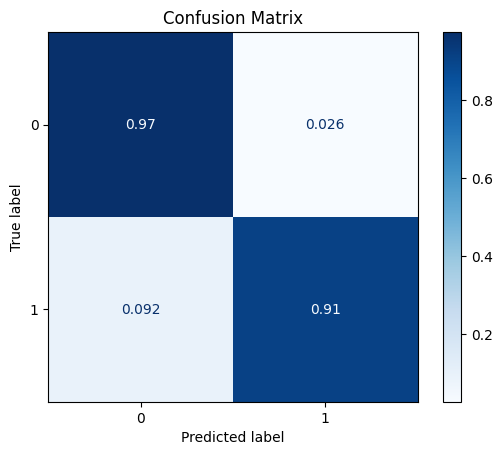

ROC AUC: 0.9681558616056434
Precision: 0.9768276288474309
Recall: 0.9702479338842975
F1: 0.9724087194198725
Accuracy: 0.9702479338842975
Optimal Threshold (ROC curve): 0.15434882044792175
Optimal Threshold (Precision x Recall curve): 0.1898476928472519
Threshold used: 0.15434882044792175


In [9]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False, plot_pr=False)


TEST SET:

[[1120   25]
 [   8   57]]


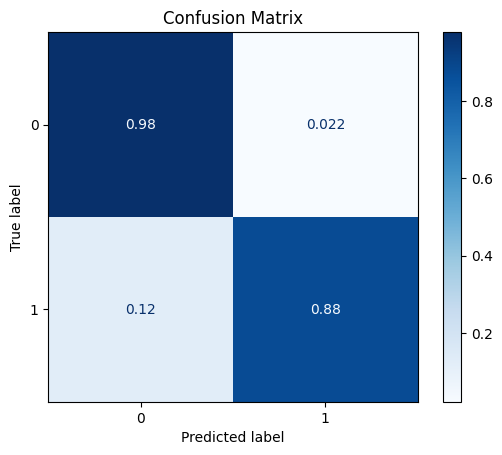

ROC AUC: 0.9348202888814242
Precision: 0.9769110408705635
Recall: 0.9727272727272728
F1: 0.9742022793999413
Accuracy: 0.9727272727272728
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [10]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="knn", train_result=False, plot_pr=False)

For a baseline, XGBoost and KNN have F1 scores around 0.86 (this will depend on your train/test split if you rerun this notebook). We will now proceed to try and improve on these results.

## 3 - Data Transformation

### DataMinMaxScaler

The first data transformation we will perform is a MinMaxScaler, which will scale each feature to have a range between zero and one. This does not improve the results.


TEST SET:

[[1018  127]
 [  23   42]]


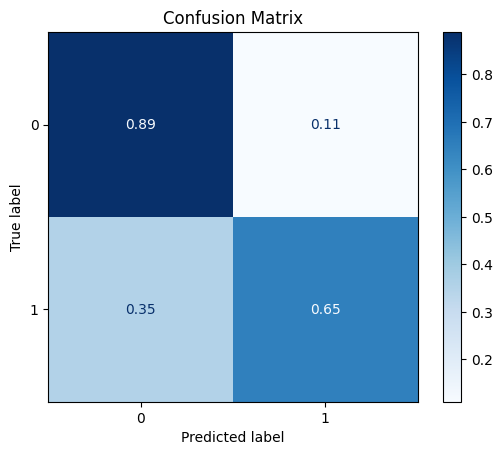

ROC AUC: 0.7821296607322807
Precision: 0.9387240128660093
Recall: 0.8760330578512396
F1: 0.9006323738087856
Accuracy: 0.8760330578512396
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [11]:
scaler = dp.DataMinMaxScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataNormalizer

Next we try `DataNormalizer`, which will scale the vectors to have unit norm (i.e. vector of length one). This is often used in text classification, but we will use it here as well. But it does not improve the results.

No columns specified for imputation. These columns have been automatically identified:
[]

TEST SET:

[[1089   56]
 [   6   59]]


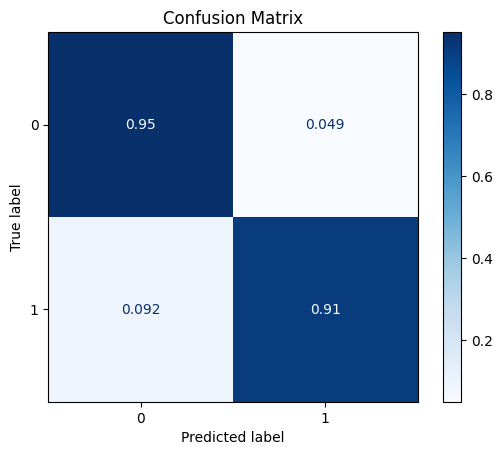

ROC AUC: 0.9453745381256298
Precision: 0.9686560772596834
Recall: 0.9487603305785124
F1: 0.9553050800209891
Accuracy: 0.9487603305785124
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [12]:
scaler = dp.DataNormalizer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataStandardScaler

The standard scaler sets the mean to zero and scales the vectors to have unit variance.


TEST SET:

[[1088   57]
 [  15   50]]


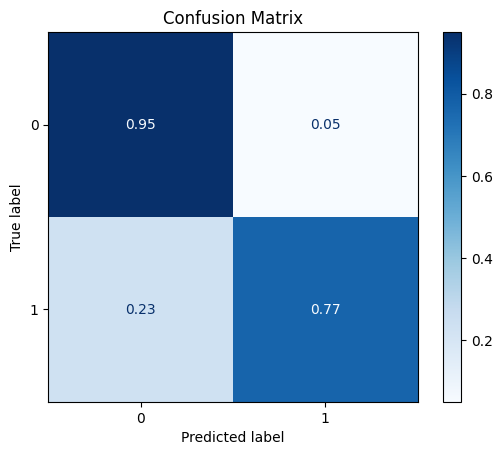

ROC AUC: 0.8714746388982196
Precision: 0.9585145968909721
Recall: 0.9404958677685951
F1: 0.9472050411649999
Accuracy: 0.9404958677685951
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [13]:
scaler = dp.DataStandardScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataQuantileTransformer

The Quantile Transformer transforms the each feature to have a normal distribution.


TEST SET:

[[1113   32]
 [  10   55]]


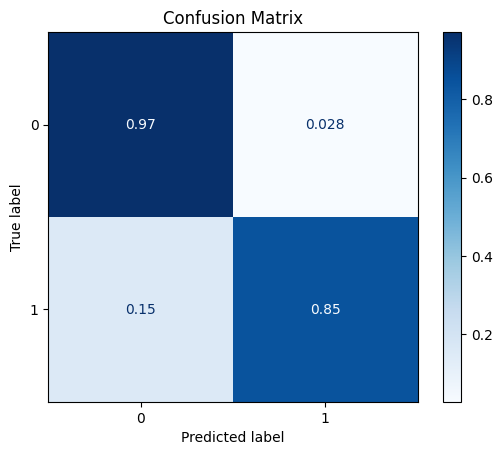

ROC AUC: 0.917991266375546
Precision: 0.9718149175156687
Recall: 0.9652892561983472
F1: 0.967632867752485
Accuracy: 0.9652892561983472
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.6
Threshold used: 0.2


In [14]:
scaler = dp.DataQuantileTransformer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataPowerTransformer

The power transformer makes the data more Gaussian-like (by default using the Yeo-Johnson transform).


TEST SET:

[[1118   27]
 [   7   58]]


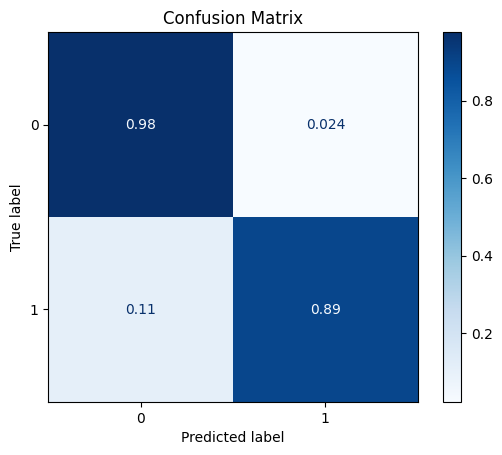

ROC AUC: 0.9416392341283171
Precision: 0.9770483444066331
Recall: 0.971900826446281
F1: 0.9736503197776726
Accuracy: 0.971900826446281
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [15]:
scaler = dp.DataPowerTransformer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataRobustScaler

The robust scaler centers the data (median=zero) and scales the data based on the interquartile range (IQR).


TEST SET:

[[1121   24]
 [   5   60]]


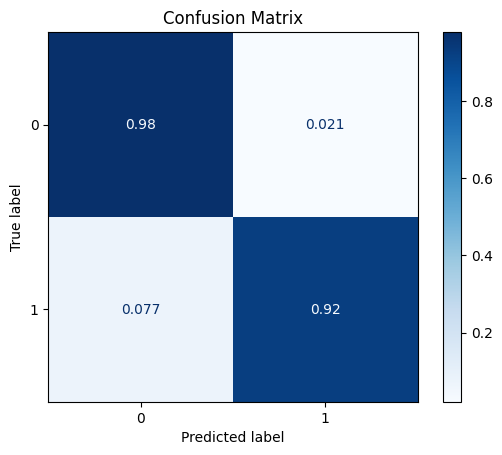

ROC AUC: 0.9579711118575748
Precision: 0.9804497537018124
Recall: 0.9760330578512396
F1: 0.9774608934639013
Accuracy: 0.9760330578512396
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [16]:
scaler = dp.DataRobustScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

As we can see, this transformation had some impact in the results (depends on the seed used) when we use KNN. Let's check how this data transformation impacts the XGBoost model:


TEST SET:

[[1115   30]
 [   6   59]]


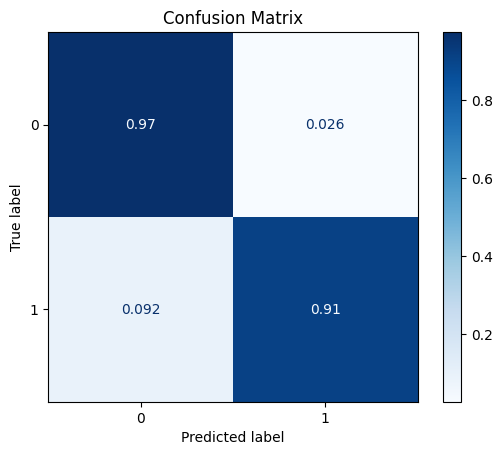

ROC AUC: 0.9681558616056434
Precision: 0.9768276288474309
Recall: 0.9702479338842975
F1: 0.9724087194198725
Accuracy: 0.9702479338842975
Optimal Threshold (ROC curve): 0.15434882044792175
Optimal Threshold (Precision x Recall curve): 0.1898476928472519
Threshold used: 0.15434882044792175


In [17]:
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="xgb", train_result=False, plot_pr=False)

As depicted above, the results for the XGBoost remains the same as before. This shows us that data transformations are more impactful in certain models and less meaningful in others.

## 4 - Feature Selection

By using data scaling (Robust Scaler), we managed to get a small performance increase. We now proceed to use feature selection over the dataset and see if we can manage to get an even higher performance. We start out with 5 features, and use feature selection to remove unneeded features.

In [18]:
feat_sel = dp.CatBoostSelection(steps=5, verbose=False)
feat_sel.fit(X=train_x_scl, y=train_y)
train_x_sel = feat_sel.transform(train_x_scl)
test_x_sel = feat_sel.transform(test_x_scl)

/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,
The number of features selection steps (5) is greater than the number of features to eliminate (3). The number of steps was reduced to 3.


In [19]:
feat_sel.get_selected_features()

['Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']

Here, ``CatBoostSelection`` feature selection has removed one of the features (GLCM_pan).


TEST SET:

[[1124   21]
 [   5   60]]


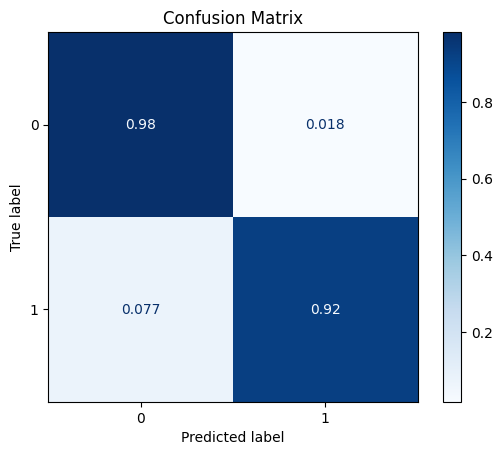

ROC AUC: 0.9586362109506215
Precision: 0.9818820570088787
Recall: 0.9785123966942149
F1: 0.9796142055841008
Accuracy: 0.9785123966942149
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [20]:
model = train_model_plot_results(train_x_sel, train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

From the previous results, we can see that we removed one of the features, but without any noticeable gains in performance. However, we are now achieving the same metrics using less data, so we can already call it successful pre-processing step.

## 5 - Synthetic Data

### imblearn Library

With unbalanced classes, we can instead choose to create synthetic data for the minority class. Here we use `Rebalance`, which connects to the `imblearn` library.

In [21]:
train_y.value_counts()

0    3433
1     196
Name: class, dtype: int64

In [22]:
rebalance = dp.Rebalance(
				X=train_x_sel,
				y=train_y,
				strategy_over={0:3433, 1:400},
				over_sampler=True,
				under_sampler=False
			)
train_x_res, train_y_res = rebalance.fit_resample()
train_y_res.value_counts()

No columns specified for imputation. These columns have been automatically identified:
[]
Running oversampling...
...finished


0    3433
1     400
Name: class, dtype: int64


TEST SET:

[[1122   23]
 [   5   60]]


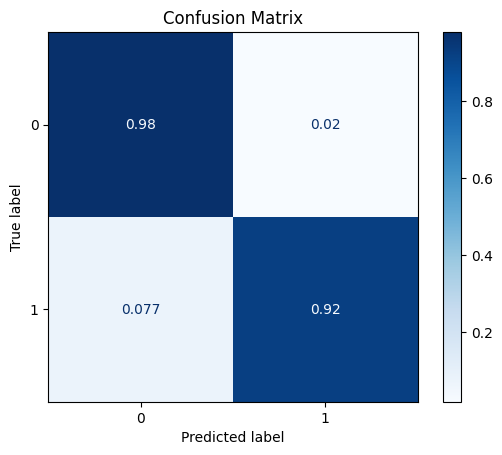

ROC AUC: 0.9583338931810548
Precision: 0.9809157799810415
Recall: 0.9768595041322314
F1: 0.9781750307518554
Accuracy: 0.9768595041322314
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [23]:
model = train_model_plot_results(train_x_res, train_y_res, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

Similarly to the feature selection step, using the **Rebalance** class didn't provide any considerable gains.

### Creating Artificial Data using Deep Learning

#### CTGAN

Let's now test rebalancing the dataset using CTGAN:

In [24]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=200,
				model="ctgan",
				load_existing=False
			)
synth.fit()

conditions = {label_col:1}	# create more of the undersampled class
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=200, conditions=conditions)

syn_train_y.value_counts()

/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate dat

0    3433
1     396
Name: class, dtype: int64


TEST SET:

[[1068   77]
 [   3   62]]


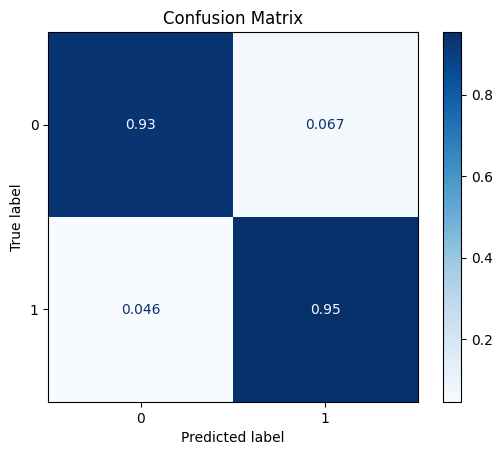

ROC AUC: 0.9698488411152169
Precision: 0.9675913411919259
Recall: 0.9338842975206612
F1: 0.9447719535945178
Accuracy: 0.9338842975206612
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.6
Threshold used: 0.2


In [25]:
model = train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

Let's try creating more artificial instances and check how this impacts the model's performance.

Sampling conditions:   0%|          | 0/2000 [00:00<?, ?it/s]/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sdv/tabular/base.py:608: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group, dataframe in grouped_conditions:
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sdv/tabular/base.py:639: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for transformed_group, transformed_dataframe in transformed_groups:
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/ctgan/data_transformer.py:149: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace inste


TEST SET:

[[1093   52]
 [   7   58]]


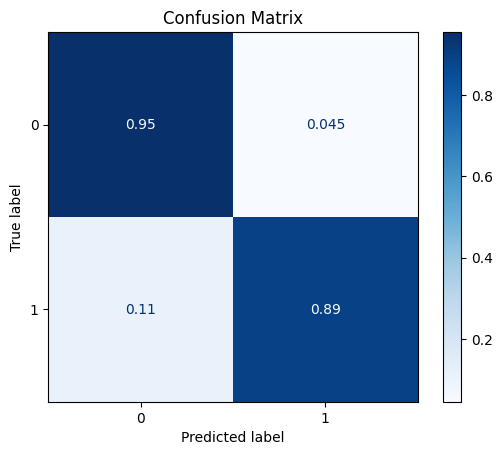

ROC AUC: 0.9670406449445751
Precision: 0.9685837716003005
Recall: 0.9512396694214876
F1: 0.9570201654996147
Accuracy: 0.9512396694214876
Optimal Threshold (ROC curve): 0.6
Optimal Threshold (Precision x Recall curve): 0.8
Threshold used: 0.6


In [26]:
conditions = {label_col:1}	# create more of the undersampled class
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=2000, conditions=conditions)

model = train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

#### TVAE

In [27]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=200,
				model="tvae",
				load_existing=False
			)
synth.fit()

conditions = {label_col:1}	# create more of the undersampled class
syn2_train_x, syn2_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=200, conditions=conditions)

/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate dat


TEST SET:

[[1058   87]
 [   5   60]]


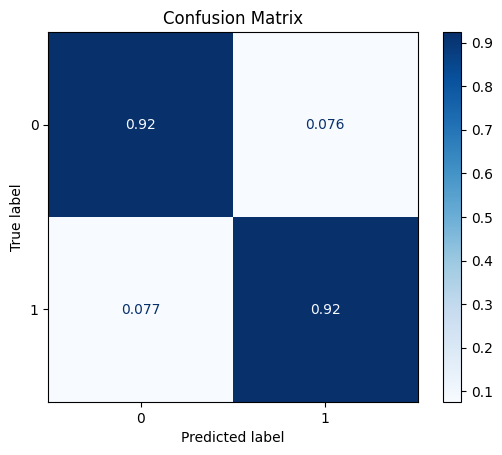

ROC AUC: 0.9530332549546524
Precision: 0.9637561251225104
Recall: 0.9239669421487603
F1: 0.9372596028899632
Accuracy: 0.9239669421487603
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.6
Threshold used: 0.2


In [28]:
model = train_model_plot_results(syn2_train_x, syn2_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)